In [9]:
import numpy as np
import pandas as pd
import sqlite3
from scipy.stats import truncnorm
from collections import defaultdict
from scipy.stats import ks_2samp, chi2_contingency
import scipy.stats as stats

import matplotlib.pyplot as plt

In [140]:
# Loading the data
dataset_1 = "Batch_1.csv"
dataset_2 = "Batch_2.csv"

df_1 = pd.read_csv(dataset_1)
df_2 = pd.read_csv(dataset_2)

In [131]:
df_1.head(5)

,Age,BusinessTravel,Department,DistanceFromHome,Education,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,OverTime,TotalWorkingYears,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,25,Travel_Rarely,Research & Development,0,Undergraduate,Male,69.305530,1,3,5,Single,6283.959320,Yes,38,6,16,10,10,13,0
1,44,Travel_Rarely,Research & Development,0,Phd,Male,72.410073,2,3,0,Divorced,4282.348662,Yes,3,5,2,10,12,6,1
2,23,Travel_Rarely,Research & Development,0,High School,Male,65.398778,5,0,4,Divorced,2029.553029,No,35,2,18,3,2,9,0
3,31,Travel_Frequently,Research & Development,0,Undergraduate,Male,60.067953,2,1,2,Divorced,5198.519177,No,18,4,16,1,1,13,0
4,51,Travel_Rarely,Sales,2,Undergraduate,Female,58.241180,1,0,5,Single,3719.390542,No,7,3,13,14,13,7,0


In [132]:
df_2.head(5)

,Age,BusinessTravel,Department,DistanceFromHome,Education,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,OverTime,TotalWorkingYears,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,22,Travel_Rarely,Sales,0,Phd,Male,74.888210,6,2,2,Single,6816.572549,No,8,3,7,13,2,3,0
1,46,Travel_Rarely,Sales,0,Masters,Male,64.959355,1,1,6,Married,5818.402001,No,38,5,1,3,3,13,0
2,47,Travel_Frequently,Sales,0,Undergraduate,Female,106.073465,2,4,3,Married,4740.545573,No,36,1,10,6,6,11,1
3,30,Travel_Rarely,Sales,0,Undergraduate,Male,66.315953,1,1,2,Single,908.509393,No,5,3,13,0,12,8,1
4,36,Travel_Rarely,Research & Development,0,High School,Female,65.746589,7,3,2,Single,8847.224006,No,39,4,7,12,7,9,1


We begin by testing the `Data Drift` function:

In [128]:
def detect_data_drift(reference_data, new_data, threshold=0.05):
    
    drift_features = []
    feature_types = defaultdict(str)  # keep track of feature types (categorical or numeric)

    # check feature types and calculate distance for each feature
    for feature in reference_data.columns:
        old_batch = reference_data[feature]
        new_batch = new_data[feature]

        # check if feature is categorical or numeric
        if np.issubdtype(old_batch.dtype, np.number):
            feature_types[feature] = 'numeric'
            ks_statistic, p_val = ks_2samp(old_batch, new_batch, method='asymp')
            if p_val < threshold:
                drift_features.append(feature)
        else:
            feature_types[feature] = 'categorical'
            old_distribution = pd.crosstab(old_batch, new_batch)
            chi2_stat, p_val, dof, expected = chi2_contingency(old_distribution)
            if p_val < threshold:
                drift_features.append(feature)
            
    return drift_features

In [133]:
detect_data_drift(df_1, df_2)

['HourlyRate']

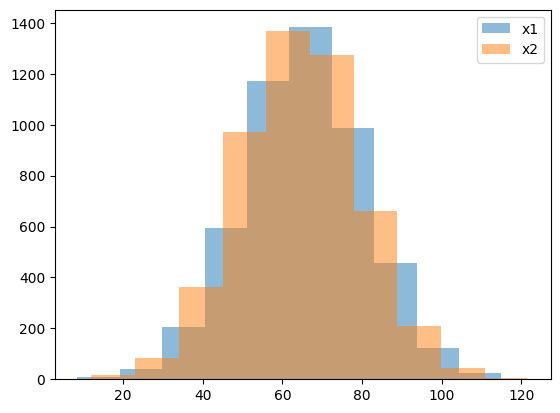

In [10]:
plt.hist(df_1['HourlyRate'], alpha=0.5, label='x1')
plt.hist(df_2['HourlyRate'], alpha=0.5, label='x2')
plt.legend(loc='upper right')
plt.show()

According to the KS test, there might be potential data drift in `HourlyRate`.

Using PSI test:

In [48]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

def psi_numeric(observed, expected):
    buckets = 10

    # Calculate the bucket boundaries
    boundaries = np.quantile(observed.index.values, np.linspace(0, 1, buckets + 1))
    boundaries[0] = -np.inf
    boundaries[-1] = np.inf

    # Group the observed and expected data based on the bucket boundaries
    observed_groups = observed.groupby(pd.cut(observed.index.values, boundaries)).count()
    expected_groups = expected.groupby(pd.cut(expected.index.values, boundaries)).count()

    # Calculate the observed and expected proportions for each group
    observed_proportions = observed_groups / observed.sum()
    expected_proportions = expected_groups / expected.sum()

    # Add missing buckets to expected proportions
    missing_buckets = observed_proportions.index.difference(expected_proportions.index)
    for bucket in missing_buckets:
        expected_proportions[bucket] = 0

    # Sort the data by the bucket boundaries
    observed_proportions.sort_index(inplace=True)
    expected_proportions.sort_index(inplace=True)

    # Calculate the PSI value
    psi_value = np.sum((observed_proportions - expected_proportions) * np.log(observed_proportions / expected_proportions)) * 100

    return psi_value

def psi_cat(ref_feature, new_feature):
    # Calculate distribution of actual and expected values
    actual_counts = ref_feature.value_counts(normalize=True, sort=False)
    expected_counts = new_feature.value_counts(normalize=True, sort=False)

    # Calculate the proportion of each distribution
    actual_prop = actual_counts / actual_counts.sum()
    expected_prop = expected_counts / expected_counts.sum()

    # Calculate the PSI value
    psi_value = ((expected_prop - actual_prop) * np.log(expected_prop / actual_prop)).sum()

    return psi_value


def calculate_psi(old_batch, current_batch, threshold=0.25):
    drift_features = []
    for feature in old_batch.columns:
        old_batch = current_batch[feature]
        new_batch = current_batch[feature]
        if np.issubdtype(old_batch.dtype, np.number):
            stat = psi_numeric(df_1[feature], df_2[feature])

            if stat > threshold:
                drift_features.append(feature)
        else:
            stat = psi_cat(df_1[feature], df_2[feature])

            if stat > threshold:
                drift_features.append(feature)

    return drift_features

calculate_psi(df_1, df_2)

['DistanceFromHome']

In [ ]:
import pandas as pd
import numpy as np

def calculate_psi_categorical(actual: pd.Series, expected: pd.Series, bins: int = 10) -> float:
    # Calculate distribution of actual and expected values
    actual_counts = actual.value_counts(normalize=True, sort=False, bins=bins)
    expected_counts = expected.value_counts(normalize=True, sort=False, bins=bins)

    # Calculate the proportion of each distribution
    actual_prop = actual_counts / actual_counts.sum()
    expected_prop = expected_counts / expected_counts.sum()

    # Calculate the PSI value
    psi_value = ((expected_prop - actual_prop) * np.log(expected_prop / actual_prop)).sum()

    return psi_value


Population Stability Index (PSI) is a statistical method used to measure the change in the distribution of a given variable between two populations or time periods. It is commonly used in credit risk management and fraud detection to evaluate whether the risk or fraud patterns of a population have changed over time.

The PSI test calculates the difference in the distribution of a variable between two populations, where each population is typically divided into several bins or intervals. The difference is measured as the PSI value, which can range from 0 to infinity. A PSI value of 0 indicates no change in the distribution, while higher values indicate greater change.

## Comparing the predictions made on old batch VS current batch:

In [53]:
def compare_preds(old_batch, current_batch, alpha = 0.05):
    # create two sets of predictions
    predictions_1 = old_batch['Attrition']
    predictions_2 = current_batch['Attrition']

    # create a contingency table
    contingency_table = pd.crosstab(predictions_1, predictions_2)

    # perform the chi-squared test
    chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)

    if p_val < alpha:
        return "Significant difference between the two sets of predictions"
    else:
        return "No significant difference between the two sets of prediction"

In [54]:
compare_preds(df_1, df_2)

'No significant difference between the two sets of prediction'

## Calculating all model KPIs

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

def calculate_model_KPI(y_true, y_pred):
    # assuming y_true and y_pred are the true and predicted labels, respectively
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, auc_roc, cm

def plot_roc():
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    # plot the ROC curve
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()



Bootstrapping for confidence level:

In [57]:
def bootstrap_f1_score(y_true, y_pred, n_bootstraps=1000, random_seed=42):
    np.random.seed(random_seed)
    f1_scores = []
    for i in range(n_bootstraps):
        indices = np.random.choice(len(y_true), len(y_true), replace=True)
        bootstrapped_y_true = y_true[indices]
        bootstrapped_y_pred = y_pred[indices]
        f1 = f1_score(bootstrapped_y_true, bootstrapped_y_pred)
        f1_scores.append(f1)
    f1_scores = np.array(f1_scores)
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    conf_int_lower = mean_f1 - 1.96 * std_f1
    conf_int_upper = mean_f1 + 1.96 * std_f1
    return mean_f1, std_f1, conf_int_lower, conf_int_upper

Distance Based

Compute the descriptive statistics (mean, variance, standard deviation, etc.) of the numeric features for both datasets.

Compute the distance between the descriptive statistics of the numeric features of both datasets using a suitable distance metric (e.g., Euclidean distance, Mahalanobis distance, etc.).

Compute the contingency tables for each categorical feature in both datasets.

Compute the distance between the contingency tables of the categorical features of both datasets using a suitable distance metric (e.g., Chi-square distance, Jaccard distance, etc.).

Aggregate the distances obtained from numeric and categorical features using a suitable aggregation function (e.g., weighted sum, mean, max, etc.) to obtain an overall distance metric.

In [100]:
numerical_cols = []
categorical_cols = []
for feature in df_1.columns:
    if np.issubdtype(df_1[feature].dtype, np.number):
        numerical_cols.append(feature)
    else:
        categorical_cols.append(feature)

numerical_cols.pop(-1)

In [104]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from collections import Counter

def compute_numerical_distance(ref_data, prod_data):
    """
    Compute the Euclidean distance between the summary statistics of two numerical columns
    """
    ref_stats = np.array([ref_data.mean(), ref_data.std(), ref_data.var()])
    prod_stats = np.array([prod_data.mean(), prod_data.std(), prod_data.var()])
    return cdist(ref_stats.reshape(1, -1), prod_stats.reshape(1, -1), metric='euclidean')[0, 0]

def compute_categorical_distance(ref_data, prod_data):
    """
    Compute the Jensen-Shannon distance between the empirical distributions of two categorical columns
    """
    ref_counts = dict(Counter(ref_data))
    prod_counts = dict(Counter(prod_data))
    all_values = list(set(ref_counts.keys()) | set(prod_counts.keys()))
    ref_probs = np.array([ref_counts.get(val, 0) / len(ref_data) for val in all_values])
    prod_probs = np.array([prod_counts.get(val, 0) / len(prod_data) for val in all_values])
    avg_probs = 0.5 * (ref_probs + prod_probs)
    js_divergence = 0.5 * (np.sum(ref_probs * np.log(ref_probs / avg_probs)) + np.sum(prod_probs * np.log(prod_probs / avg_probs)))
    #print(js_divergence)
    return np.sqrt(js_divergence)

def compute_overall_distance(ref_df, prod_df, numerical_cols, categorical_cols, numerical_weights=None):
    """
    Compute the overall distance metric between the reference and production dataframes
    """
    if numerical_weights is None:
        numerical_weights = [1] * len(numerical_cols)
    num_distance = 0
    cat_distance = 0
    for i, col in enumerate(numerical_cols):
        num_distance += numerical_weights[i] * compute_numerical_distance(ref_df[col], prod_df[col])
        print(num_distance)
    for col in categorical_cols:
        cat_distance += compute_categorical_distance(ref_df[col], prod_df[col])

       # print(cat_distance)
    return num_distance + cat_distance

def test_for_drift(ref_data, prod_data, numerical_cols, categorical_cols, numerical_weights=None, threshold=0.1):
    """
    Test for covariate drift between the reference and production dataframes
    """
    distance = compute_overall_distance(ref_data, prod_data, numerical_cols, categorical_cols, numerical_weights)
    return distance >= threshold


In [145]:
# Loading the data
dataset_1 = "Batch_1.csv"
dataset_2 = "Batch_2.csv"

df_1 = pd.read_csv(dataset_1)
df_2 = pd.read_csv(dataset_2)

In [142]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the numeric columns in the dataframe
df_1[numerical_cols] = scaler.fit_transform(df_1[numerical_cols])
df_2[numerical_cols] = scaler.transform(df_2[numerical_cols])

In [143]:
test_for_drift(df_1, df_2, numerical_cols, categorical_cols)

True

In [135]:
def detect_data_drift(reference_data, new_data, threshold=0.05):
    
    drift_features = []
    drift_features_cat = []
    
    # check feature types and calculate distance for each feature
    for feature in reference_data.columns:
        old_batch = reference_data[feature]
        new_batch = new_data[feature]

        # check if feature is categorical or numeric
        if np.issubdtype(old_batch.dtype, np.number):
            ks_statistic, p_val = ks_2samp(old_batch, new_batch)
            if p_val < threshold:
                #drift_dict['ks_2samp'] = p_val
                drift_features.append(feature)
                #feature_names.append(feature)
        else:
            #feature_types[feature] = 'categorical'
            old_distribution = pd.crosstab(old_batch, new_batch)
            chi2_stat, p_val, dof, expected = chi2_contingency(old_distribution)
            if p_val < threshold:
                drift_features_cat.append(feature)
                #feature_names_cat.append(feature)
    return drift_features_cat, drift_features


def psi_numeric(observed, expected):
    buckets = 10


    # Calculate the bucket boundaries
    boundaries = np.quantile(observed.index.values, np.linspace(0, 1, buckets + 1))
    boundaries[0] = -np.inf
    boundaries[-1] = np.inf

    # Group the observed and expected data based on the bucket boundaries
    observed_groups = observed.groupby(pd.cut(observed.index.values, boundaries)).count()
    expected_groups = expected.groupby(pd.cut(expected.index.values, boundaries)).count()

    # Calculate the observed and expected proportions for each group
    observed_proportions = observed_groups / observed.sum()
    expected_proportions = expected_groups / expected.sum()

    # Add missing buckets to expected proportions
    missing_buckets = observed_proportions.index.difference(expected_proportions.index)
    for bucket in missing_buckets:
        expected_proportions[bucket] = 0

    # Sort the data by the bucket boundaries
    observed_proportions.sort_index(inplace=True)
    expected_proportions.sort_index(inplace=True)

    # Calculate the PSI value
    psi_value = np.sum((observed_proportions - expected_proportions) * np.log(observed_proportions / expected_proportions)) * 100

    return psi_value

def psi_cat(ref_feature, new_feature):
    # Calculate distribution of actual and expected values
    actual_counts = ref_feature.value_counts(normalize=True, sort=False)
    expected_counts = new_feature.value_counts(normalize=True, sort=False)

    # Calculate the proportion of each distribution
    actual_prop = actual_counts / actual_counts.sum()
    expected_prop = expected_counts / expected_counts.sum()

    # Calculate the PSI value
    psi_value = ((expected_prop - actual_prop) * np.log(expected_prop / actual_prop)).sum()

    return psi_value


def calculate_psi(old_batch, current_batch, threshold=0.25):
    drift_features = []

    for feature in old_batch.columns:
        df_1 = old_batch[feature]
        df_2 = current_batch[feature]
        if np.issubdtype(df_1.dtype, np.number):
            stat = psi_numeric(df_1, df_2)

            if stat > threshold:
                drift_features.append(feature)
        else:
            stat = psi_cat(df_1, df_2)

            if stat > threshold:
                drift_features.append(feature)
    return drift_features




import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from collections import Counter

def compute_numerical_distance(ref_data, prod_data):
    """
    Compute the Euclidean distance between the summary statistics of two numerical columns
    """
    ref_stats = np.array([ref_data.mean(), ref_data.std(), ref_data.var()])
    prod_stats = np.array([prod_data.mean(), prod_data.std(), prod_data.var()])
    return cdist(ref_stats.reshape(1, -1), prod_stats.reshape(1, -1), metric='euclidean')[0, 0]

def compute_categorical_distance(ref_data, prod_data):
    """
    Compute the Jensen-Shannon distance between the empirical distributions of two categorical columns
    """
    ref_counts = dict(Counter(ref_data))
    prod_counts = dict(Counter(prod_data))
    all_values = list(set(ref_counts.keys()) | set(prod_counts.keys()))
    ref_probs = np.array([ref_counts.get(val, 0) / len(ref_data) for val in all_values])
    prod_probs = np.array([prod_counts.get(val, 0) / len(prod_data) for val in all_values])
    avg_probs = 0.5 * (ref_probs + prod_probs)
    js_divergence = 0.5 * (np.sum(ref_probs * np.log(ref_probs / avg_probs)) + np.sum(prod_probs * np.log(prod_probs / avg_probs)))
    #print(js_divergence)
    return np.sqrt(js_divergence)

def compute_overall_distance(ref_df, prod_df, numerical_cols, categorical_cols, numerical_weights=None):
    """
    Compute the overall distance metric between the reference and production dataframes
    """
    if numerical_weights is None:
        numerical_weights = [1] * len(numerical_cols)
    num_distance = 0
    cat_distance = 0
    for i, col in enumerate(numerical_cols):
        num_distance += numerical_weights[i] * compute_numerical_distance(ref_df[col], prod_df[col])
        #print(num_distance)
    for col in categorical_cols:
        cat_distance += compute_categorical_distance(ref_df[col], prod_df[col])

       # print(cat_distance)
    return num_distance + cat_distance

def test_for_drift(ref_data, prod_data, numerical_cols, categorical_cols, numerical_weights=None, threshold=0.1):
    """
    Test for covariate drift between the reference and production dataframes
    """
    distance = compute_overall_distance(ref_data, prod_data, numerical_cols, categorical_cols, numerical_weights)
    return distance >= threshold



In [146]:
def drift_detector(old_data, new_data):
    drift_dict = defaultdict()

    # KS_test and Chi_sq test for numeric and categorical features respectively
    cat_features, num_features = detect_data_drift(old_data, new_data, threshold=0.05)
    drift_dict['KS_test'] = num_features
    drift_dict['Chi_Sq'] = cat_features

    psi_features = calculate_psi(old_data, new_data)
    drift_dict['PSI'] = psi_features

    numerical_cols = []
    categorical_cols = []
    for feature in old_data.columns:
        if np.issubdtype(df_1[feature].dtype, np.number):
            numerical_cols.append(feature)
        else:
            categorical_cols.append(feature)
    res = test_for_drift(old_data, new_data, numerical_cols, categorical_cols, threshold=0.1)

    drift_dict['Distance_based'] = res

    return drift_dict

In [147]:
drift_detector(df_1, df_2)

C:\Users\alvee\AppData\Local\Temp\ipykernel_17772\2970299182.py:13: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  ks_statistic, p_val = ks_2samp(old_batch, new_batch)
C:\Users\alvee\AppData\Local\Temp\ipykernel_17772\2970299182.py:13: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  ks_statistic, p_val = ks_2samp(old_batch, new_batch)


defaultdict(None,
            {'KS_test': ['HourlyRate'],
             'Chi_Sq': [],
             'PSI': ['DistanceFromHome'],
             'Distance_based': True})

In [163]:
df_1['Attrition'] = df_1['Attrition'].replace({1: 'Yes', 0: 'No'})

df_2['Attrition'] = df_2['Attrition'].replace({1: 'Yes', 0: 'No'})

In [155]:
np.unique(df_1['Attrition'], return_counts=True)

(array(['No', 'Yes'], dtype=object), array([1764, 3236], dtype=int64))

In [164]:
df_key, val = np.unique(df_1['Attrition'], return_counts=True)

df_key_2, val_2 = np.unique(df_2['Attrition'], return_counts=True)
df_key, df_key_2

(array(['No', 'Yes'], dtype=object), array(['No', 'Yes'], dtype=object))

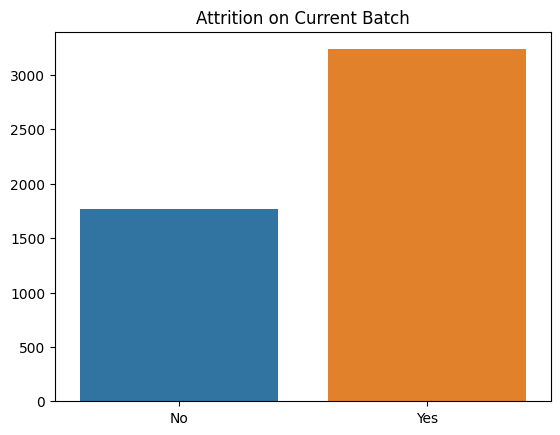

In [172]:
import seaborn as sns

sns.barplot(x=df_key, y=val)
plt.title('Attrition on Current Batch')

plt.show()

# Data Functions

In [5]:
import numpy as np
import pandas as pd

def generate_data(n_samples = 15000):
    """
    generate data
    """   
    # define means and standard deviations for continuous variables
    age_mean = 35
    age_std = 10
    
    monthly_income_mean = 3000
    monthly_income_std = 2000
   
    # generate continuous variables
    age = np.round(np.random.normal(age_mean, age_std, n_samples),0).astype(int)
    monthly_income = np.random.normal(monthly_income_mean, monthly_income_std, n_samples)
    
    # define parameter values for discrete variables
    distance_param = 0.4
    job_inv_param = 2
    job_sat_param = 3   
    work_life_bal_param = 3
    
    # generate discrete variables
    distance_from_home = np.random.negative_binomial(distance_param, 1-distance_param, n_samples)
    job_involvement = np.random.poisson(job_inv_param, n_samples)
    job_satisfaction = np.random.poisson(job_sat_param, n_samples)
    work_life_balance = np.random.poisson(work_life_bal_param, n_samples)
    
    # define category names and probabilities for categorical variables
    business_travel_cat = ['Travel_Rarely', 'Travel_Frequently', 'Non-Travel']
    business_travel_prob = [0.7, 0.2, 0.1]
    
    department_cat = ['Sales', 'Research & Development', 'Human Resources']
    department_prob = [0.4, 0.5, 0.1]
    
    education_field_cat = ['High School', 'Undergraduate', 'Masters', 'Phd']
    education_field_prob = [0.2, 0.4, 0.2, 0.2]
    
    marital_status_cat = ['Married', 'Single', 'Divorced']
    marital_status_prob = [0.4, 0.4, 0.2]
    
    gender_cat = ['Male', 'Female']
    gender_prob = [0.6, 0.4]

    # generate categorical variables
    business_travel = np.random.choice(business_travel_cat, n_samples, p=business_travel_prob)
    department = np.random.choice(department_cat, n_samples, p=department_prob)
    education_level = np.random.choice(education_field_cat, n_samples, p=education_field_prob)
    marital_status = np.random.choice(marital_status_cat, n_samples, p=marital_status_prob)
    gender = np.random.choice(gender_cat, n_samples, p=gender_prob)


    # combine all variables into a pandas dataframe
    data = pd.DataFrame({'Age': age,
                        'BusinessTravel': business_travel,
                        'Department': department,
                        'DistanceFromHome': distance_from_home,
                        'Education': education_level,
                        'Gender': gender,
                        'JobInvolvement': job_involvement,
                        'JobSatisfaction': job_satisfaction,
                        'MaritalStatus': marital_status,
                        'MonthlyIncome': monthly_income,
                        'OverTime': np.random.choice(['Yes', 'No'], n_samples, p=[0.25, 0.75]),
                        'TotalWorkingYears': np.random.randint(0, 40, n_samples),
                        'WorkLifeBalance': work_life_balance,
                        'YearsAtCompany': np.random.randint(0, 20, n_samples),
                        'YearsInCurrentRole': np.random.randint(0, 15, n_samples),
                        'YearsSinceLastPromotion': np.random.randint(0, 15, n_samples),
                        'YearsWithCurrManager': np.random.randint(0, 15, n_samples)})

    return data

In [6]:
employee_data = generate_data()

In [8]:
employee_data['DistanceFromHome'].describe()

count    15000.000000
mean         0.262800
std          0.661941
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          9.000000
Name: DistanceFromHome, dtype: float64

In [ ]:
# define the function to create the classification label
def create_label(row):
    if row['Department'] == 'Sales' and row['JobSatisfaction'] <= 3 and row['YearsSinceLastPromotion'] > 5:
        return 1
    elif row['Department'] == 'Human Resources' and row['YearsAtCompany'] < 3 and row['MaritalStatus'] == 'Married' and row['OverTime'] == 'Yes':
        return 1
    elif (row['Department'] == 'Research & Development' and row['YearsAtCompany'] > 8) or (row['OverTime'] == 'No' and row['YearsSinceLastPromotion'] < 4):
        return 0
    elif row['Age'] < 35 and row['Gender'] == 'Male' and row['BusinessTravel'] == 'Travel_Frequently' and ((row['YearsWithCurrManager'] < 2) or row['Education']=='Undergraduate'):
        return 1
    elif (row['Age'] > ((row['YearsWithCurrManager'] + row['TotalWorkingYears']) * row['YearsAtCompany'])) or ((row['MonthlyIncome'] > 300) and (row['JobInvolvement'] > 3)):
        return 1
    elif row['Age'] < 35 and row['MonthlyIncome'] < 3500 and row['Education'] == 'High School':
        return 1
    else:
        return 0
               

# apply the function to create the classification label for each row in the dataset
employee_data['Attrition'] = employee_data.apply(create_label, axis=1)

employee_data['OverTime'] = employee_data['OverTime'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
def drift_generate_data(n_samples=15000, gradual_change=True, feature_to_change=None):
    generate_data()

    # determine which feature to change and how to change it
    if feature_to_change is None:
        feature_to_change = np.random.choice(['Age', 'MonthlyIncome'])
    if gradual_change:
        data = gradual_change_data(data=data, feature=feature_to_change)
    else:
        data[feature_to_change] = sudden_change_data(data=data, feature=feature_to_change)


In [21]:
# select numerical columns
numerical_cols = data.select_dtypes(include=np.number).columns.tolist()

# select categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

In [22]:
def get_num_cat_columns(data):
    numerical_cols = data.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

    return numerical_cols, categorical_cols

['BusinessTravel',
 'Department',
 'Education',
 'Gender',
 'MaritalStatus',
 'OverTime']

In [2]:
import random

# Get column names
col_names = data.columns.tolist()

# Randomly pick 3 column names
random_col_names = random.sample(col_names, k=3)

NameError: name 'data' is not defined

In [24]:
random_col_names

['Age', 'OverTime', 'DistanceFromHome']

In [26]:
for i in random_col_names:
    if i in categorical_cols:
        print(True)
    else:
        print(False)

False
True
False


In [15]:
import random
lst = ['SUDDEN', ['GRADUAL']]

drift_typ = random.choice(['GRADUAL', 'SUDDEN'])

drift_typ

'SUDDEN'